<a href="https://colab.research.google.com/github/kiplangatkorir/-Time-Series-Forecasting-of-Stock-Prices/blob/main/poc_weather_dkgcs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
pip install networkx requests pyvis matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 32.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 42.0 MB/s eta 0:00:00


In [73]:
import networkx as nx
from typing import Dict, List, Tuple
import requests
import time
import random
from pyvis.network import Network
import matplotlib.pyplot as plt
from IPython.display import IFrame

In [79]:
class DKGCS:
    def __init__(self, confidence_threshold=0.5):
        self.graph = nx.Graph()
        self.confidence_threshold = confidence_threshold

    def add_node(self, node: str, attributes: Dict = None):
        """Add a node to the graph with optional attributes."""
        # If attributes is None, provide an empty dictionary to avoid the error
        if attributes is None:
            attributes = {}
        self.graph.add_node(node, **attributes)

    def add_edge(self, node1: str, node2: str, confidence: float):
        """Add an edge between two nodes with a confidence score."""
        self.graph.add_edge(node1, node2, confidence=confidence)

    def update_confidence(self, node1: str, node2: str, new_confidence: float):
        """Update the confidence score of an edge."""
        if self.graph.has_edge(node1, node2):
            old_confidence = self.graph[node1][node2]['confidence']
            # Simple averaging for demonstration purposes
            updated_confidence = (old_confidence + new_confidence) / 2
            self.graph[node1][node2]['confidence'] = updated_confidence

    def query(self, start_node: str, depth: int = 2) -> List[Tuple[str, float]]:
        """Perform a simple query starting from a node."""
        results = []
        for node in nx.bfs_tree(self.graph, start_node, depth_limit=depth):
            if node != start_node:
                path = nx.shortest_path(self.graph, start_node, node)
                confidence = self._calculate_path_confidence(path)
                if confidence >= self.confidence_threshold:
                    results.append((node, confidence))
        return sorted(results, key=lambda x: x[1], reverse=True)

    def _calculate_path_confidence(self, path: List[str]) -> float:
        """Calculate the confidence of a path."""
        confidences = [self.graph[path[i]][path[i+1]]['confidence']
                       for i in range(len(path)-1)]
        return min(confidences)  # Using minimum for demonstration

    def consistency_check(self) -> List[Tuple[str, str, float]]:
        """Perform a basic consistency check on the graph."""
        inconsistencies = []
        for node1, node2, data in self.graph.edges(data=True):
            if data['confidence'] < self.confidence_threshold:
                inconsistencies.append((node1, node2, data['confidence']))
        return inconsistencies

    def resolve_conflict(self, old_data: Dict, new_data: Dict) -> Dict:
        """
        Resolve conflicts between old and new data based on confidence scores.
        """
        old_confidence = old_data.get("confidence", 0.5)
        new_confidence = new_data.get("confidence", 0.5)

        if new_confidence > old_confidence:
            return new_data
        elif new_confidence == old_confidence:
            return {**old_data, **new_data}  # Merge attributes if confidence is same
        else:
            return old_data

    def add_or_update_edge_with_conflict(self, node1: str, node2: str, new_data: Dict):
        if self.graph.has_edge(node1, node2):
            old_data = self.graph[node1][node2]
            resolved_data = self.resolve_conflict(old_data, new_data)
            self.graph[node1][node2].update(resolved_data)
        else:
            self.graph.add_edge(node1, node2, **new_data)

    def visualize_graph_matplotlib(self):
        """
        Visualize the graph using Matplotlib and NetworkX.
        """
        plt.figure(figsize=(12, 8))
        pos = nx.spring_layout(self.graph)

        # Draw nodes
        nx.draw_networkx_nodes(self.graph, pos, node_size=700, node_color='lightblue')

        # Draw edges
        edge_colors = [self.graph[u][v]['confidence'] for u, v in self.graph.edges()]
        nx.draw_networkx_edges(self.graph, pos, edge_color=edge_colors, edge_cmap=plt.cm.YlOrRd, width=2)

        # Draw labels
        nx.draw_networkx_labels(self.graph, pos, font_size=10)

        # Add edge labels (confidence scores)
        edge_labels = nx.get_edge_attributes(self.graph, 'confidence')
        nx.draw_networkx_edge_labels(self.graph, pos, edge_labels=edge_labels)

        plt.title("Dynamic Knowledge Graph")
        plt.axis('off')
        plt.tight_layout()
        plt.show()

    def visualize_graph_matplotlib(self):
        """
        Visualize the graph using matplotlib for a static plot.
        """
        pos = nx.spring_layout(self.graph)
        edge_labels = nx.get_edge_attributes(self.graph, 'confidence')

        nx.draw(self.graph, pos, with_labels=True, node_color='skyblue', node_size=2000, font_size=10)
        nx.draw_networkx_edge_labels(self.graph, pos, edge_labels=edge_labels)
        plt.show()

In [80]:
# Simulating real-time updates from a weather API

def fetch_weather_data(city: str, api_key: str) -> Dict:
    """
    Fetch real-time weather data from the OpenWeatherMap API.
    """
    url = f"http://api.openweathermap.org/data/2.5/weather?q={city}&appid=0d923cbc47a7f289f483db9c3943e141"
    response = requests.get(url)

    if response.status_code == 200:
        data = response.json()
        temp = data['main']['temp'] - 273.15  # Convert from Kelvin to Celsius
        weather_desc = data['weather'][0]['description']
        confidence = random.uniform(0.7, 1.0)  # Simulating confidence score

        return {
            "city": city,
            "temp": temp,
            "weather": weather_desc,
            "confidence": confidence
        }
    else:
        print(f"Failed to fetch data for {city}: {response.status_code}")
        return {}


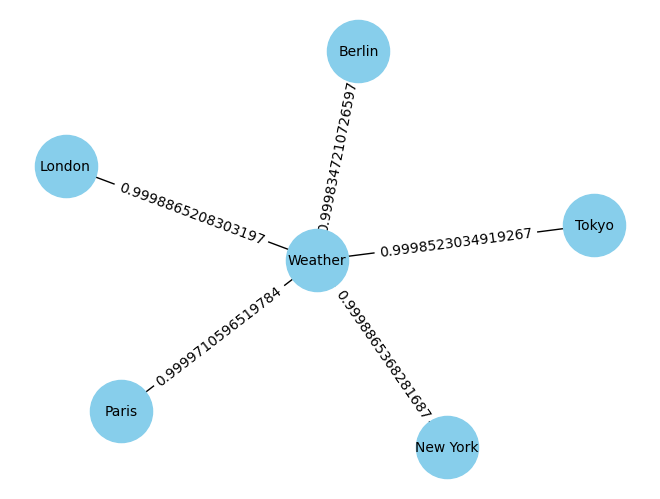

None

In [ ]:
from IPython.display import display, clear_output

if __name__ == "__main__":
    api_key = "your_openweather_api_key"
    dkgcs = DKGCS(confidence_threshold=0.5)

    cities = ["London", "Paris", "Berlin", "New York", "Tokyo"]
    for city in cities:
        dkgcs.add_node(city)

    while True:
        for city in cities:
            weather_data = fetch_weather_data(city, api_key)
            if weather_data:
                dkgcs.add_or_update_edge_with_conflict(
                    weather_data["city"], "Weather", {
                        "confidence": weather_data["confidence"],
                        "temp": weather_data["temp"],
                        "description": weather_data["weather"]
                    }
                )
                print(f"Updated graph with {city} weather data.")

        # Clear previous output and display new graph
        clear_output(wait=True)
        display(dkgcs.visualize_graph_matplotlib())
        time.sleep(10)  # Pause for 10 seconds between updates